In [88]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.optimize as sco
import yfinance as yf

np.random.seed(777)

#plt.style.use('fivethirtyeight')
#%matplotlib inline
#%config InlineBackend.figure_format = 'retina'

In [89]:
rics = ['NFLX', 'AAPL', 'MSFT', 'TSLA', 'NVDA', 'META', 'GOOG', 'AMD']

In [90]:
data = yf.download(rics, start='2022-12-31')['Adj Close']
data = data.dropna()
data.head()

[*********************100%***********************]  8 of 8 completed


,AAPL,AMD,GOOG,META,MSFT,NFLX,NVDA,TSLA
Date,,,,,,,,
2023-01-03 00:00:00-05:00,124.879326,64.019997,89.699997,124.739998,238.981430,294.950012,143.149994,108.099998
2023-01-04 00:00:00-05:00,126.167366,64.660004,88.709999,127.370003,228.527618,309.410004,147.490005,113.639999
2023-01-05 00:00:00-05:00,124.829399,62.330002,86.769997,126.940002,221.754562,309.700012,142.649994,110.339996
2023-01-06 00:00:00-05:00,129.422394,63.959999,88.160004,130.020004,224.368011,315.549988,148.589996,113.059998
2023-01-09 00:00:00-05:00,129.951584,67.239998,88.800003,129.470001,226.552551,315.170013,156.279999,119.769997


In [96]:
mean_returns

AAPL    0.005377
AMD     0.006203
GOOG    0.001200
META    0.010698
MSFT    0.001923
NFLX    0.004407
NVDA    0.011800
TSLA    0.019342
dtype: float64

In [91]:
def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    p_var, p_ret = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
    return -(p_ret - risk_free_rate) / p_var

def max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(neg_sharpe_ratio, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result

In [92]:
def portfolio_volatility(weights, mean_returns, cov_matrix):
    return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[0]

def min_variance(mean_returns, cov_matrix):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))

    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)

    return result

In [93]:
def efficient_return(mean_returns, cov_matrix, target):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)

    def portfolio_return(weights):
        return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[1]

    constraints = ({'type': 'eq', 'fun': lambda x: portfolio_return(x) - target},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0,1) for asset in range(num_assets))
    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    return result


def efficient_frontier(mean_returns, cov_matrix, returns_range):
    efficients = []
    for ret in returns_range:
        efficients.append(efficient_return(mean_returns, cov_matrix, ret))
    return efficients

In [94]:
def display_ef_with_selected(mean_returns, cov_matrix, risk_free_rate):
    max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
    sdp, rp = portfolio_annualised_performance(max_sharpe['x'], mean_returns, cov_matrix)
    max_sharpe_allocation = pd.DataFrame(max_sharpe.x,index=data.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T

    min_vol = min_variance(mean_returns, cov_matrix)
    sdp_min, rp_min = portfolio_annualised_performance(min_vol['x'], mean_returns, cov_matrix)
    min_vol_allocation = pd.DataFrame(min_vol.x,index=data.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    an_vol = np.std(returns) * np.sqrt(252)
    an_rt = mean_returns * 252
    
    print("-"*80)
    print("Maximum Sharpe Ratio Portfolio Allocation\n")
    print("Annualised Return:", round(rp,2))
    print("Annualised Volatility:", round(sdp,2))
    print("\n")
    print(max_sharpe_allocation)
    print("-"*80)
    print("Minimum Volatility Portfolio Allocation\n")
    print("Annualised Return:", round(rp_min,2))
    print("Annualised Volatility:", round(sdp_min,2))
    print("\n")
    print(min_vol_allocation)
    print("-"*80)
    print("Individual Stock Returns and Volatility\n")
    for i, txt in enumerate(data.columns):
        print(txt,":","Annualised return",round(an_rt[i],2),", Annualised volatility:",round(an_vol[i],2))
    print("-"*80)
    
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.scatter(an_vol,an_rt,marker='o',s=200)

    for i, txt in enumerate(data.columns):
        ax.annotate(txt, (an_vol[i],an_rt[i]), xytext=(10,0), textcoords='offset points')
    ax.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    ax.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')

    target = np.linspace(rp_min, 0.34, 50)
    efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target)
    ax.plot([p['fun'] for p in efficient_portfolios], target, linestyle='-.', color='black', label='Efficient Frontier')
    ax.set_title('Portfolio Optimization with Individual Stocks')
    ax.set_xlabel('Annualised Volatility')
    ax.set_ylabel('Annualised Returns')
    ax.legend(labelspacing=0.8)

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 2.96
Annualised Volatility: 0.4


             AAPL  AMD  GOOG  META  MSFT  NFLX  NVDA   TSLA
allocation  50.88  0.0   0.0  5.84   0.0   0.0   0.0  43.28
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 1.24
Annualised Volatility: 0.24


            AAPL  AMD  GOOG  META  MSFT  NFLX  NVDA  TSLA
allocation  80.1  0.0   0.0   0.0  9.93  9.97   0.0   0.0
--------------------------------------------------------------------------------
Individual Stock Returns and Volatility

AAPL : Annualised return 1.35 , Annualised volatility: 0.24
AMD : Annualised return 1.56 , Annualised volatility: 0.6
GOOG : Annualised return 0.3 , Annualised volatility: 0.46
META : Annualised return 2.7 , Annualised volatility: 0.71
MSFT : Annualised return 0.48 , Annualised volatility

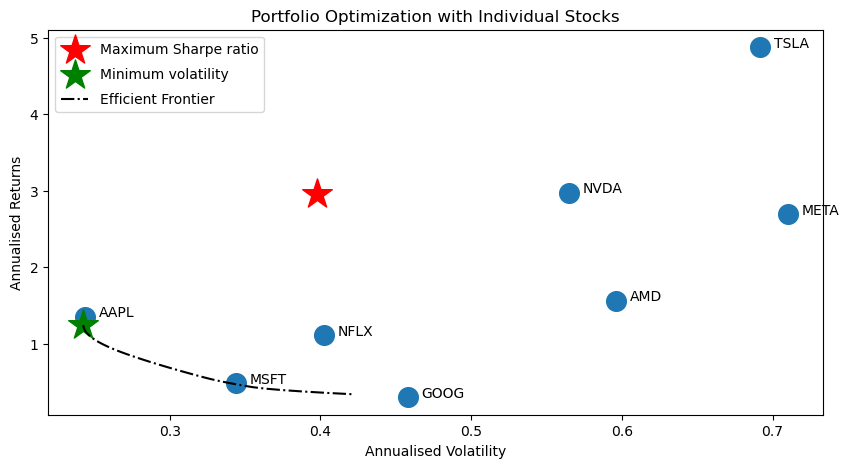

In [95]:
display_ef_with_selected(mean_returns, cov_matrix, risk_free_rate)